<a href="https://colab.research.google.com/github/gabrie1-s/phosphorus_analysis/blob/main/Analise_fosforo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importação das bibliotecas e leitura dos dados

In [ ]:
%%capture
!pip install Bayesian-Optimization
!pip install xgboost
!pip install ray

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
import os
import gc
import pdb
import ray
import keras
import xgboost
import tensorflow
from scipy import stats
from sklearn import metrics
from xgboost import XGBRegressor
from keras.models import load_model
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
fosforo = pd.read_excel("/content/drive/MyDrive/CNN_Chagas/fosforo/fosforo2.xlsx")

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
def prepare_data(df):
  df.columns = df.iloc[0]
  df = df.iloc[1:, :]
  df = df[["P medido (mg/L)","TOA  B2", "TOA B3"]]
  df.dropna(inplace=True)
  return df

#2. Análise exploratória e preprocessamento

In [ ]:
dataset = fosforo.astype(float)

In [ ]:
dataset.columns

Index(['TOA  B2', 'TOA B3', 'TOA B3 / TOA B2', 'P medido (mg/L)'], dtype='object')

In [ ]:
dataset.drop(columns=['TOA B3 / TOA B2'], inplace=True)
dataset.columns = ['B2', 'B3', 'P']
dataset = dataset[['P', 'B2', 'B3']]

print("min: " + str(dataset['P'].min()))
print("max: " + str(dataset['P'].max()))

# dataset['P'] = (dataset['P'] - dataset['P'].min())/ (dataset['P'].max() - dataset['P'].min())

# dataset['1/B2'] = 1/dataset['B2']
# dataset['1/B3'] = 1/dataset['B3']
# dataset['ln(B2)'] = np.log(dataset['B2'])
# dataset['ln(B3)'] = np.log(dataset['B3'])
# dataset['1/ln(B2)'] = 1/np.log(dataset['B2'])
# dataset['1/ln(B3)'] = 1/np.log(dataset['B3'])
# dataset['B3^B2^4'] = dataset['B3']**dataset['B2']

dataset['B3/B2'] = dataset['B3']/dataset['B2']
dataset['ln(B3)/ln(B2)'] = np.log(dataset['B3'])/np.log(dataset['B2'])
dataset['B3 ln(B2) / B2 ln(B3)'] = (dataset['B3'] * np.log(dataset['B2'])) / (dataset['B2'] * np.log(dataset['B3']))


min: 0.01
max: 0.31214285714285717


<ipython-input-280-21877d727f6c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['B3/B2'] = dataset['B3']/dataset['B2']
<ipython-input-280-21877d727f6c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ln(B3)/ln(B2)'] = np.log(dataset['B3'])/np.log(dataset['B2'])
<ipython-input-280-21877d727f6c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

## 2.1. Teste de componentes polinomiais por meio de correlação de Spearmen

Aqui testaremos novas combinações entre as vairáveis B2 e B3. O objetivo é encontrar relações não lineares entre essas variáveis que se correlacionem com a variável P. Encontramos 3 relações promissoras: B3/B2, ln(B3)/ln(B2) e (B3 * ln(B2)) / (B2 * ln(B3)).

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(degree=5, include_bias=False)
poly_features = poly.fit_transform(dataset.drop('P', axis=1))
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(dataset.drop('P', axis=1).columns))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


In [ ]:
poly_df

In [ ]:
poly_df['P'] = dataset['P']
poly_df.corr(method='spearman')['P']

##2.1. Breve observação

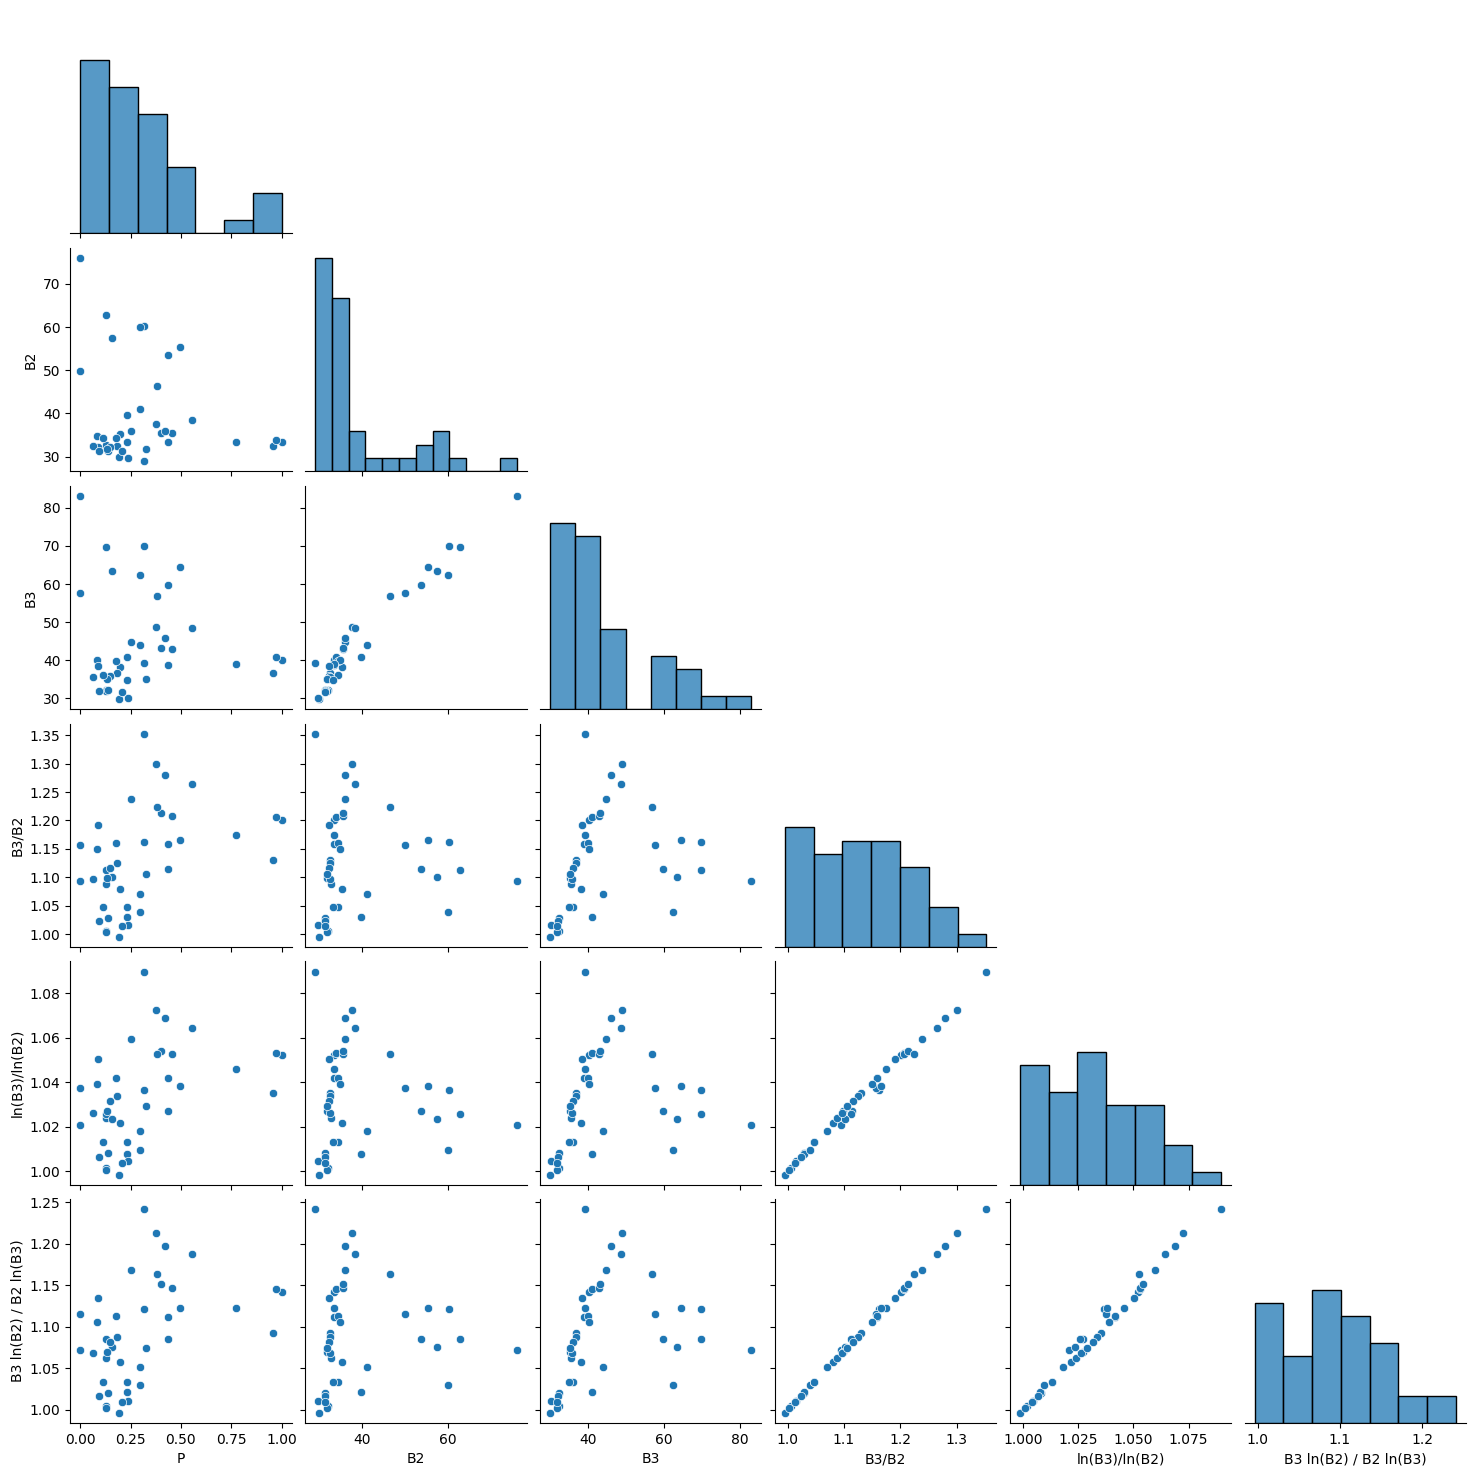

In [ ]:
sns.pairplot(dataset, corner=True)
plt.show()

Observe no conjunto de gráficos de dispersão acima que a variável B2 parece estar altamente correlacionada com a variável B3. Notamos isso pelo comportamento quase linear dos pontos do gráfico 'TOA B2' x 'TOA B3'. Em contrapartida, não parece haver relção entre B3 e 'P medido' ou B2 e 'P medido'.  Além disso, no mapa de calor fica evidente a maior correlação da variável P com a razão B3/B2. Embora tal correlação não seja significativa, é consideravelmente maior que as demais correlações da variável P.

Text(0.5, 1.0, 'Mapa de calor da correlação entre as variáveis')

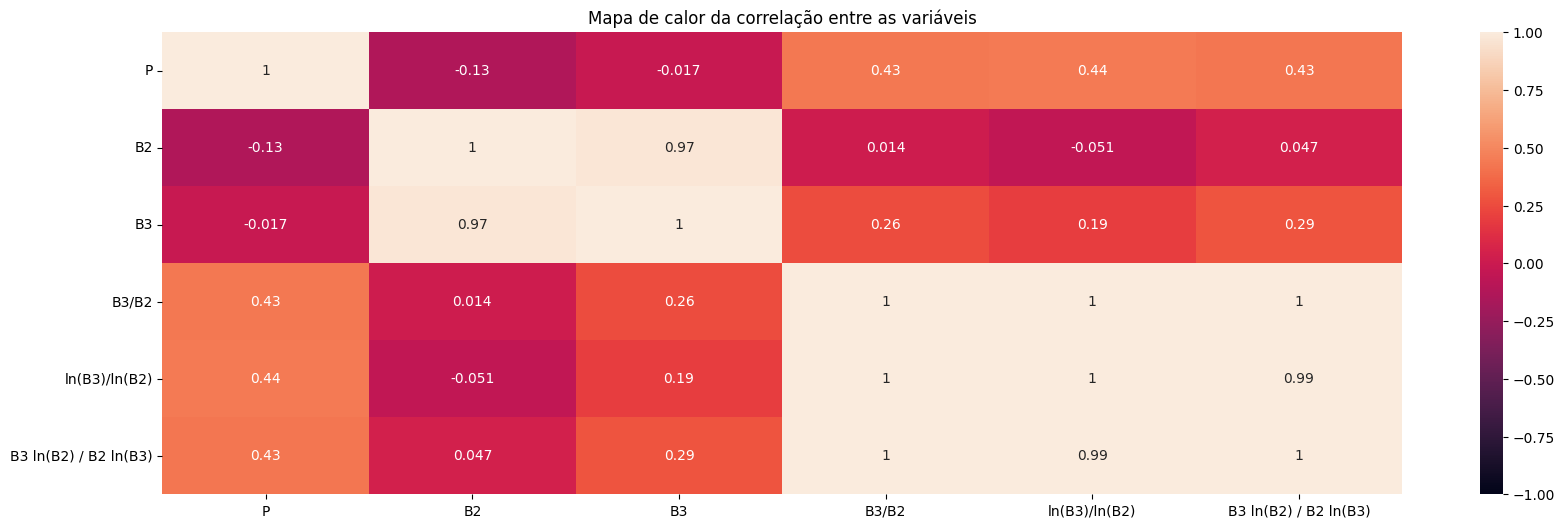

In [ ]:
#Sem transformação
ax = sns.heatmap(dataset.corr(), annot=True, vmin=-1, vmax=1)
ax.set_title("Mapa de calor da correlação entre as variáveis")

No mapa de calor acima, podemos visualizar as correlações entre as variáveis. Vemos que as informações do mapa de calor apenas confirmam o que foi dito anteriormente: as variáveis B2 e B3 são altamente correlacionadas entre si e ambas tem pouca (ou nenhuma) correlação com a variável P. Além disso, no mapa de calor fica evidente a maior correlação da variável P com a razão B3/B2. Embora tal correlação não seja significativa, é consideravelmente maior que as demais correlações da variável P.

$\textbf{Nota}$ : a correlação entre duas variáveis $x$ e $y$ é dada por:
\begin{equation}
  \rho_{x, y} = \frac{covariance(x, y)}{\sigma_{x} \cdot \sigma_{y}}
\end{equation}

O valor de $\rho_{x,y}$ é tal que: $-1 \leq \rho_{x,y} \leq 1$. Quanto maior o módulo de $\rho_{x,y}$ maior a correlação entre $x$ e $y$. Quanto mais próximo $\rho_{x,y}$ for de zero, menor a correlação.

Como o módulo da correla B2 e B3, significa que a variável B2 acresecnta muito pouca informação a B3 e vice-versa. Em casos de correlação tão elevada, normalmente, elimina-se uma das variáveis ou substitui-se as variáveis por uma combinação linear de ambas. Entretanto, como desconheço o problema (só me foi dito que deveria tentar predizer P com base, apenas, em B2 e B3 😅) decidi manter ambas as variáveis.

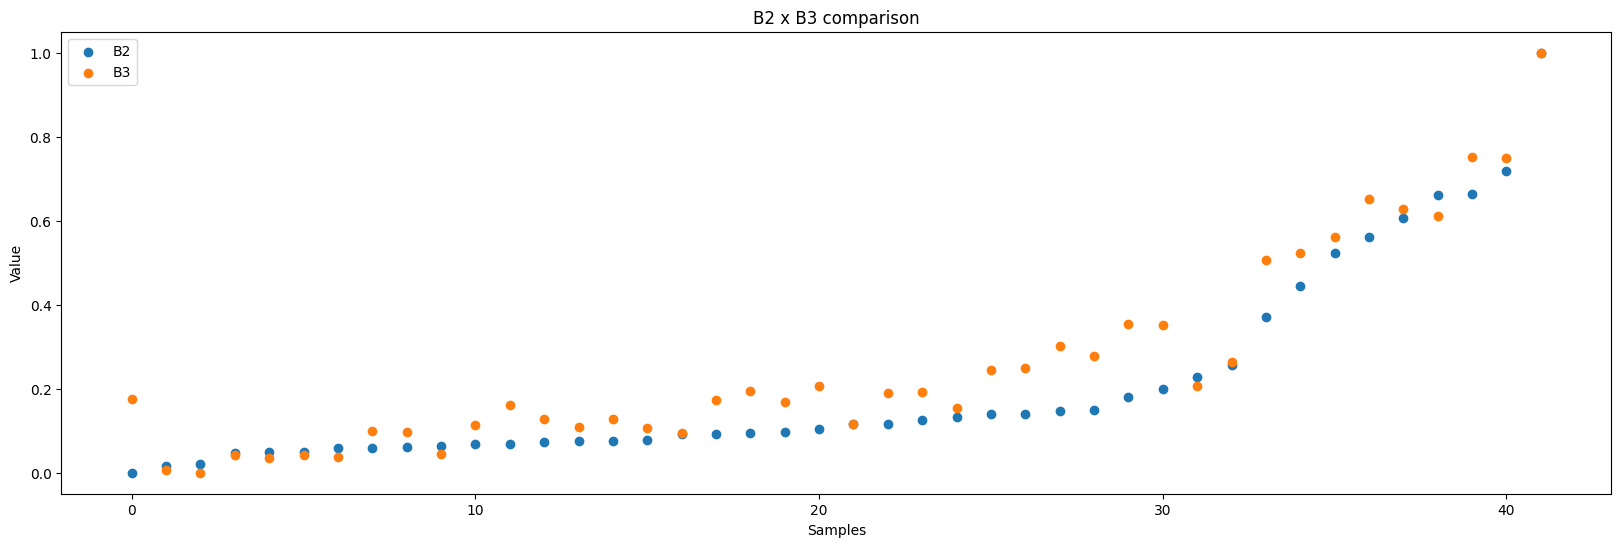

In [ ]:
b2 = np.array(dataset[dataset.columns[1]])
b3 = np.array(dataset[dataset.columns[2]])

b2 = (b2-b2.min())/((b2.max()-b2.min()))
b3 = (b3-b3.min())/((b3.max()-b3.min()))

b3 = [x for _, x in sorted(zip(b2, b3))]
b2 = sorted(b2)

plt.rcParams["figure.figsize"] = (20,6)

plt.scatter(range(len(b2)), b2)
plt.scatter(range(len(b2)), b3)
plt.title('B2 x B3 comparison')
plt.ylabel('Value')
plt.xlabel('Samples')
plt.legend(['B2', 'B3'], loc='upper left')
plt.show()

Como forma de visualizar melhor essa correlação, fizmeos o plot acima, perceba que os valores de B3 seguem a mesma tendência de crescimento de B2.

**OBS**.: Para plotarmos o gráfico acima, ordenamos os valores de B2 e reposicionamos os valores de B3 de forma a não alterar os pares (B2, B3) do conjunto de dados original.

##2.4. Análise bivariada / correlações entre os dados

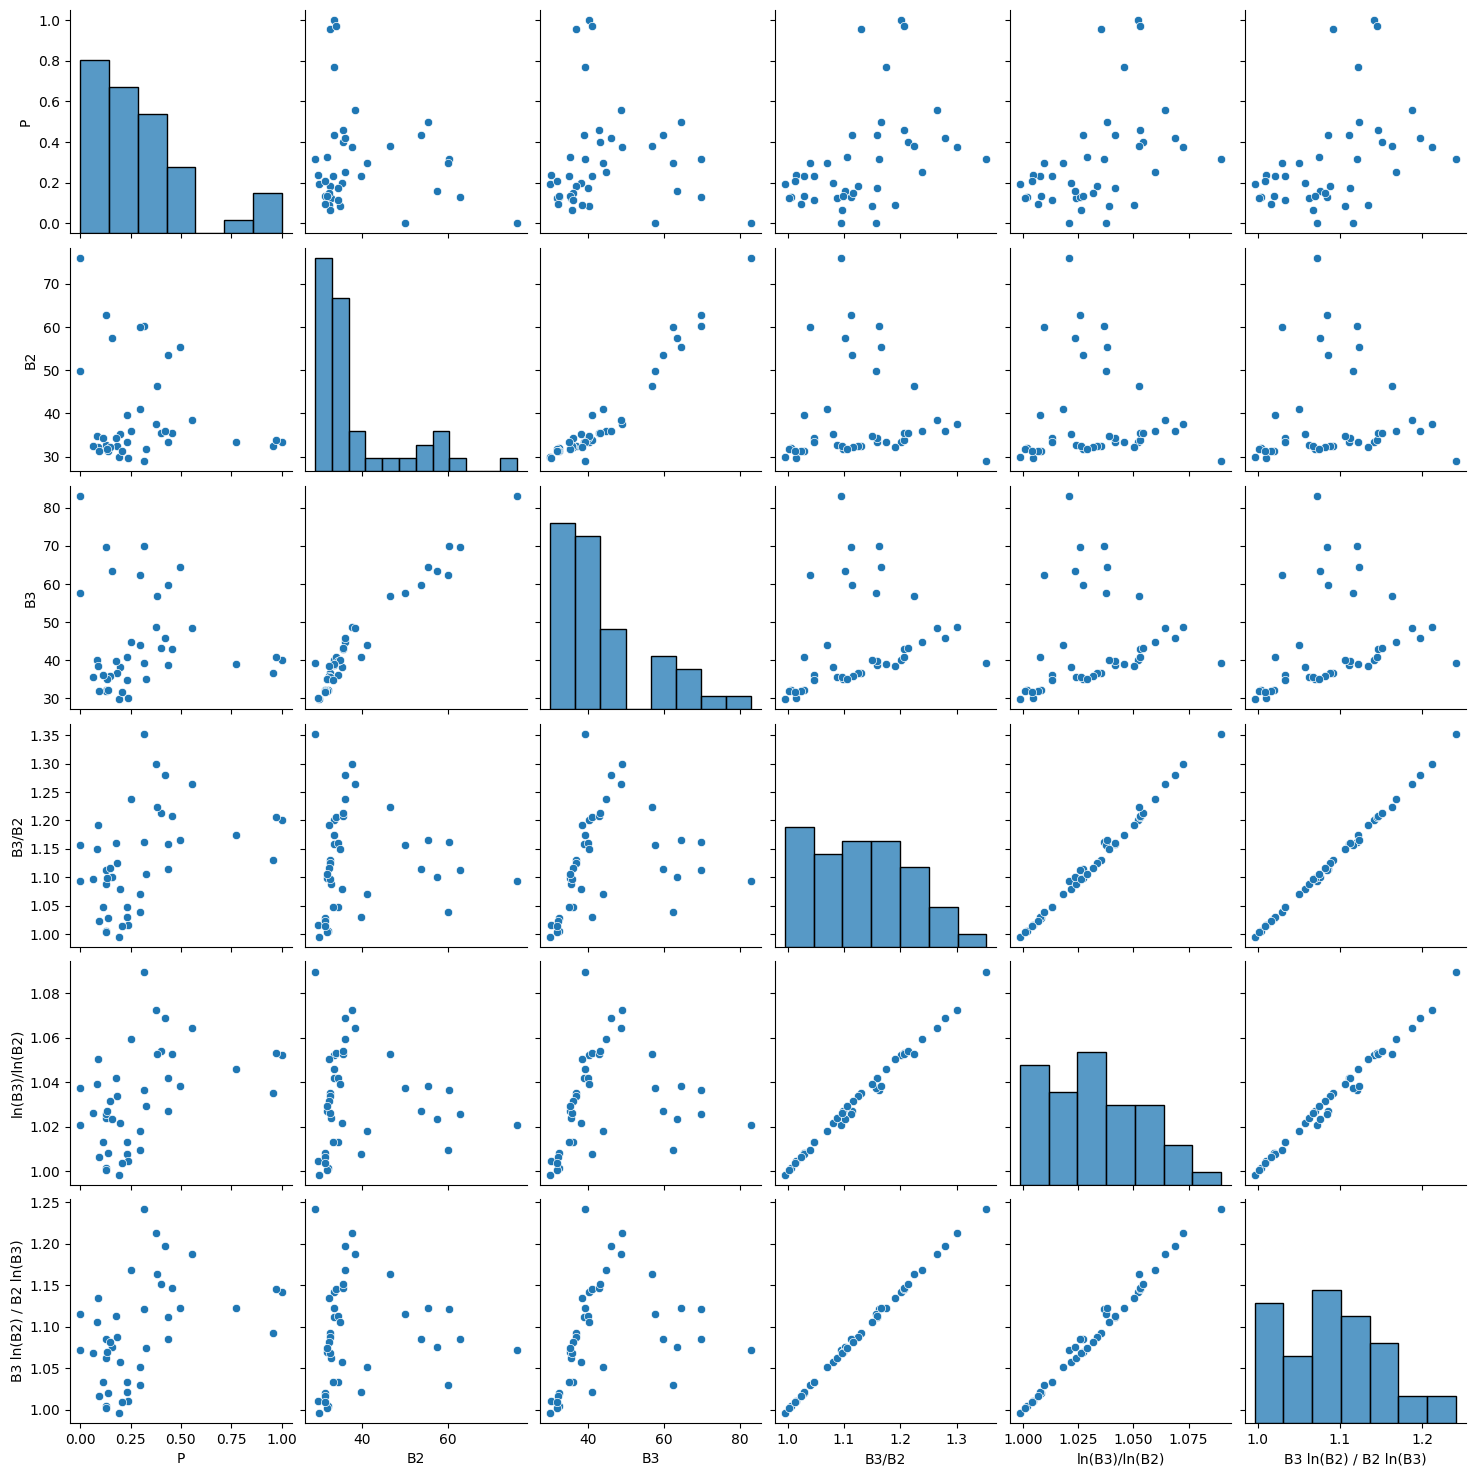

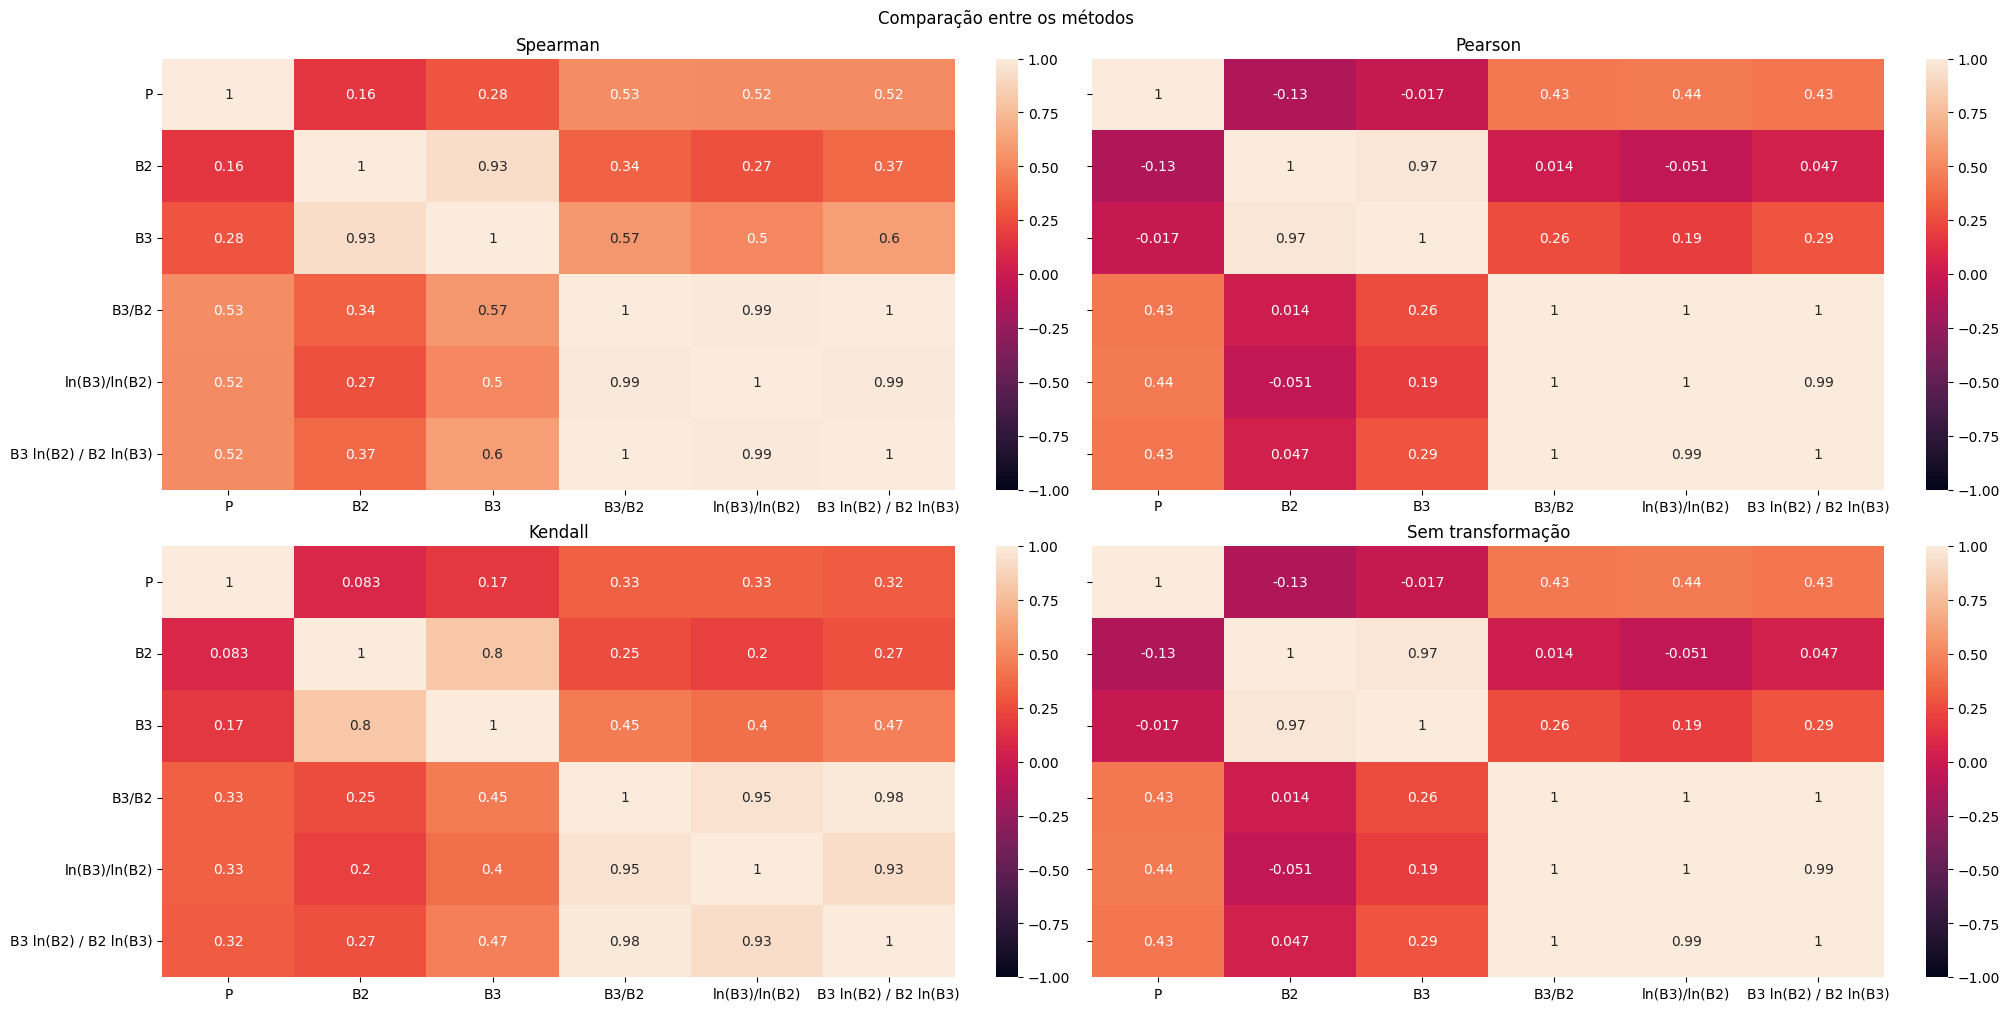

In [ ]:
sns.pairplot(dataset)
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True, constrained_layout=True)
fig.suptitle('Comparação entre os métodos')

#Spearman
ax = sns.heatmap(dataset.corr(method='spearman'), annot=True, vmin=-1, vmax=1, ax = axes[0,0])
axes[0,0].set_title("Spearman")
bottom, top = ax.get_ylim()

#Pearson
ax = sns.heatmap(dataset.corr(method='pearson'), annot=True, vmin=-1, vmax=1, ax = axes[0,1])
axes[0,1].set_title("Pearson")
bottom, top = ax.get_ylim()

#Kendall
ax = sns.heatmap(dataset.corr(method='kendall'), annot=True, vmin=-1, vmax=1, ax = axes[1,0])
bottom, top = ax.get_ylim()
axes[1,0].set_title("Kendall")

#Sem transformação
ax = sns.heatmap(dataset.corr(), annot=True, vmin=-1, vmax=1, ax = axes[1,1])
axes[1,1].set_title("Sem transformação")
bottom, top = ax.get_ylim()

Aqui a análise é semelhante à que fizemos no início: B2 e B3 são altamente correlacionados e, mesmo usando métodos não lineares de correlação (Pearson, Kendall e Spearman) a correlação deles com P é baixa. Além disso, a correlação de spearman da variável B3/B2 com a variável P é moderada. Isso nos leva às seguintes conclusões.



*   A informação das variáveis B2 e B3 é, em grande parte, reduntante (como já vimos anteriormente);
*   Como não existe nenhuma correlação forte com P, dificilmente métodos lineares de regressão terão bom desempenho ao tentar predizer P a partir de B2, B3 e B3/B2.



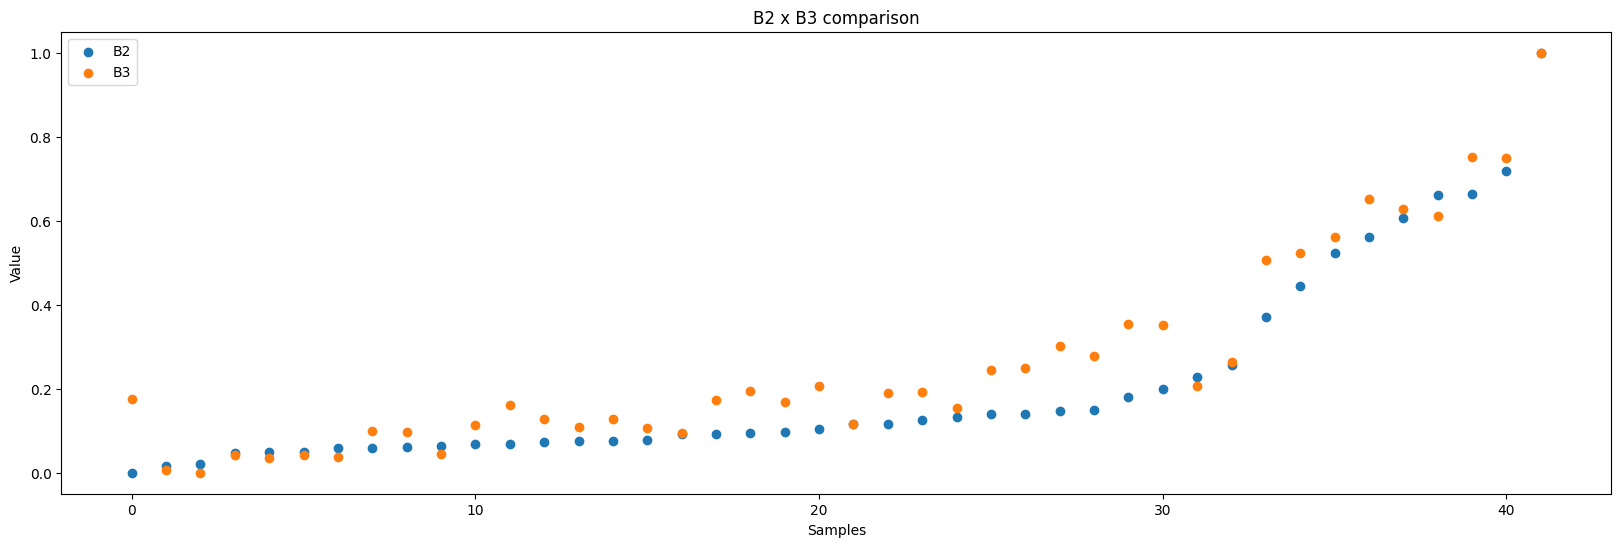

In [ ]:
b2 = np.array(dataset[dataset.columns[1]])
b3 = np.array(dataset[dataset.columns[2]])

b2 = (b2-b2.min())/((b2.max()-b2.min()))
b3 = (b3-b3.min())/((b3.max()-b3.min()))

b3 = [x for _, x in sorted(zip(b2, b3))]
b2 = sorted(b2)

plt.scatter(range(len(b2)), b2)
plt.scatter(range(len(b2)), b3)
plt.title('B2 x B3 comparison')
plt.ylabel('Value')
plt.xlabel('Samples')
plt.legend(['B2', 'B3'], loc='upper left')
plt.show()

Aqui, fizemos esse plot apenas para mostrar que B2 e B3 continuam altamente correlacionadas, mesmo após as transformações.

#3. Algoritmos de regressão

Dividiremos o conjunto de dados em treino e teste. Deixamos o conjunto de teste com apenas 15% das amostras, pois, como temos poucos dados, queremos maximizar o número de amostras de treinamento. Por esse mesmo motivo, optamos por usar cross validation ao invés de criar um conjunto de validação.

In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(dataset[dataset.columns[1:]], dataset[dataset.columns[0]], test_size=0.15, random_state=3)

In [ ]:
def plot_results(y_pred, y_tes):
  plt.scatter(range(len(y_pred)), y_pred, c='r')
  plt.plot(range(len(y_tes)), y_tes, linestyle="-", marker="o", label="Expenses")
  plt.title('Model performance - test set')
  plt.ylabel('P medido')
  plt.xlabel('Sample')
  plt.legend(['predicted', 'real'], loc='upper left')
  plt.show()

Antes de implementarmos os modelos de regressão, gostaria de deixar claro que usaremos duas métricas principais para avaliar o desempenho de nossos modelos:



*   Erro percentual médio absoluto (mean absolute percentage error):
\begin{equation}
  MAPE = \frac{1}{n} \sum_{i = 1}^{n} \frac{|y_i - p_i|}{y_i}
\end{equation}

*   Erro médio absoluto (mean absolute error):
\begin{equation}
  MAE = \frac{1}{n} \sum_{i = 1}^{n} |y_i - p_i|
\end{equation}

*   $R^2$ score:
\begin{equation}
  R^2 = NSE = 1 - \frac{\sum_{i=1}^{N} (y_i - p_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y_i})^2}
\end{equation}

Onde, $y_i$ é o valor real,  $p_i$ é o valor predito pelo modelo testado e $\bar{y_i}$ é a média dos valores de $y_i$, $\forall i$.


##3.1. Métodos Lineares

In [ ]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

In [ ]:
def train_test_model(model, x_tr, y_tr, x_te, y_te, folds=5):
  kf = KFold(n_splits = folds, random_state = 1, shuffle=True)
  scores = cross_validate(model, x_tr, y_tr, cv=kf,
                        scoring = ('neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  std_mae = np.std(scores['test_neg_mean_absolute_error']*(-1))

  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  std_mpae = np.std(scores['test_neg_mean_absolute_percentage_error']*(-1))

  r2 = np.mean(scores['test_r2'])
  std_r2 = np.std(scores['test_r2'])

  print('--------------------Validação Cruazada-----------------------')
  print("Média dos valore de MAE: " + str(mae))
  print("Desvio padrão dos valore de MAE: " + str(std_mae) + "\n")

  print("Média dos valore de MAPE: " + str(mape))
  print("Desvio padrão dos valore de MAPE: " + str(std_mpae) + "\n")

  print("Média dos valore de R2: " + str(r2))
  print("Desvio padrão dos valore de R2: " + str(std_r2) + "\n")

  print('--------------------Teste-----------------------')
  model.fit(x_tr, y_tr)
  y_pred = model.predict(x_te)
  print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
  print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
  print("R2: " + str(r2_score(y_te, y_pred)))

  plot_results(model.predict(x_te), y_te)

###3.2.1. Regressão Linear

**Teste com 5-Folds**

In [ ]:
dataset.columns

Index(['P', 'B2', 'B3', 'B3/B2', 'ln(B3)/ln(B2)', 'B3 ln(B2) / B2 ln(B3)'], dtype='object')

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.27481480486072596
Desvio padrão dos valore de MAE: 0.11148594715168504

Média dos valore de MAPE: 44420116354405.62
Desvio padrão dos valore de MAPE: 88840232708809.2

Média dos valore de R2: -17.309527302366465
Desvio padrão dos valore de R2: 33.250121008189936

--------------------Teste-----------------------
MAE: 0.13760778140886548
MAPE: 82503602572974.66
R2: -0.4993537953523619


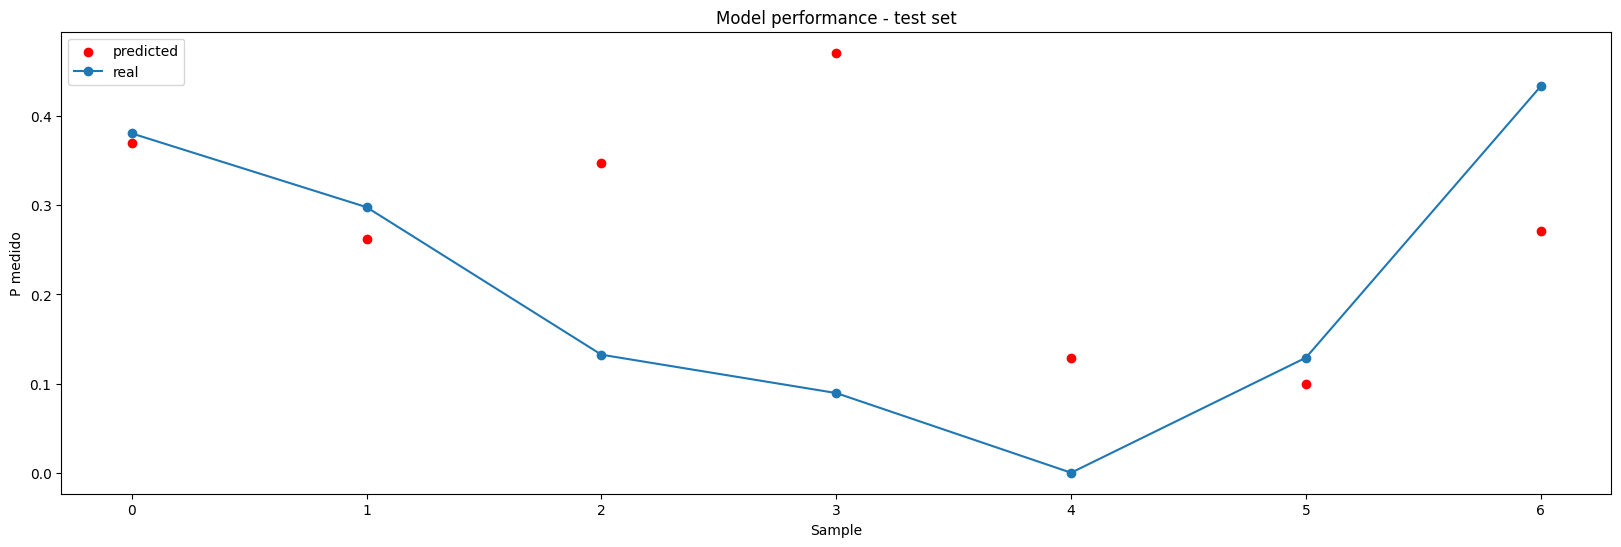

In [ ]:
linear_regressor = sklm.LinearRegression()
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.25413935882941785
Desvio padrão dos valore de MAE: 0.18571406629632722

Média dos valore de MAPE: 40470054486600.59
Desvio padrão dos valore de MAPE: 121410163459798.88

Média dos valore de R2: -21.6403494884018
Desvio padrão dos valore de R2: 53.871727844926355

--------------------Teste-----------------------
MAE: 0.13760778140886548
MAPE: 82503602572974.66
R2: -0.4993537953523619


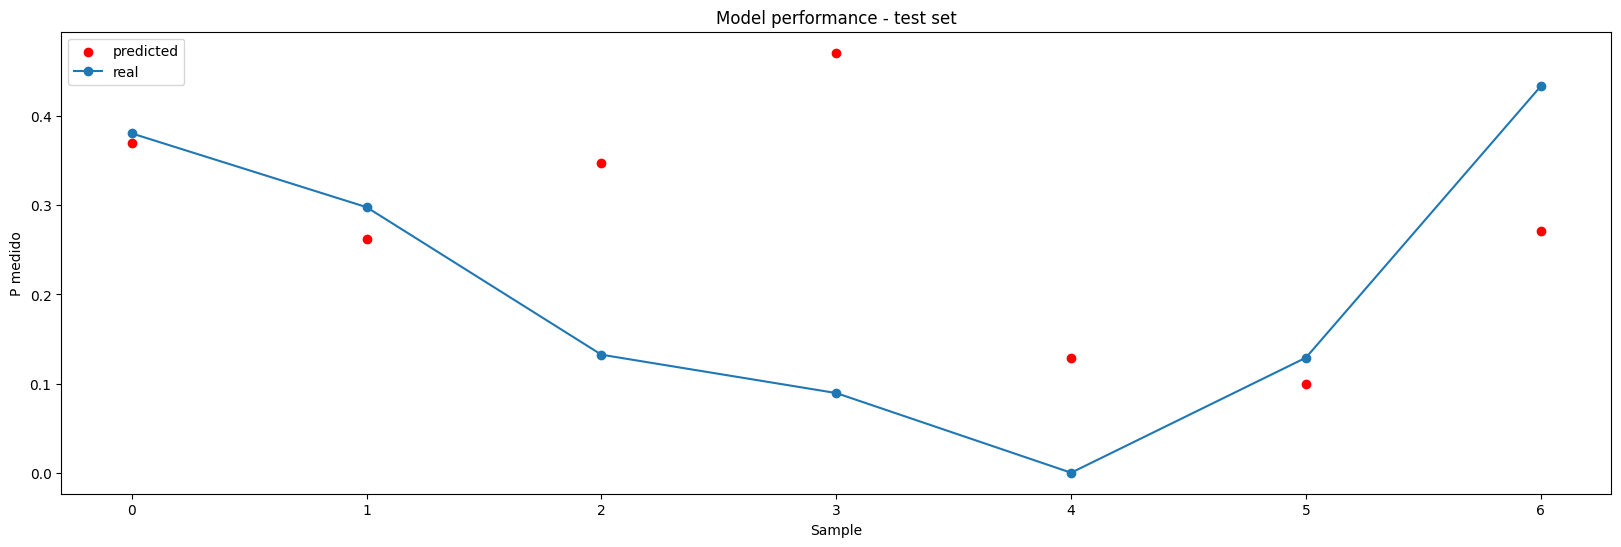

In [ ]:
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, folds=10)

In [ ]:
print("Coeficientes da regressão linear: " + str(linear_regressor.coef_))

Coeficientes da regressão linear: [  0.07997619  -0.07965715 -41.65312364  34.71394839  52.94498951]


###3.2.2. Rgressão Ridge

In [ ]:
ray.init()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# definindo espaço de busca para os lambdas
lambdas = np.linspace(0, 100, 1000)

**Teste com 5-Folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=5,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

Lambda:50.550550550550554
Best MAE: 0.18008753853946788
Best MAPE: 41310368449714.17
R2: -0.3323177630796604


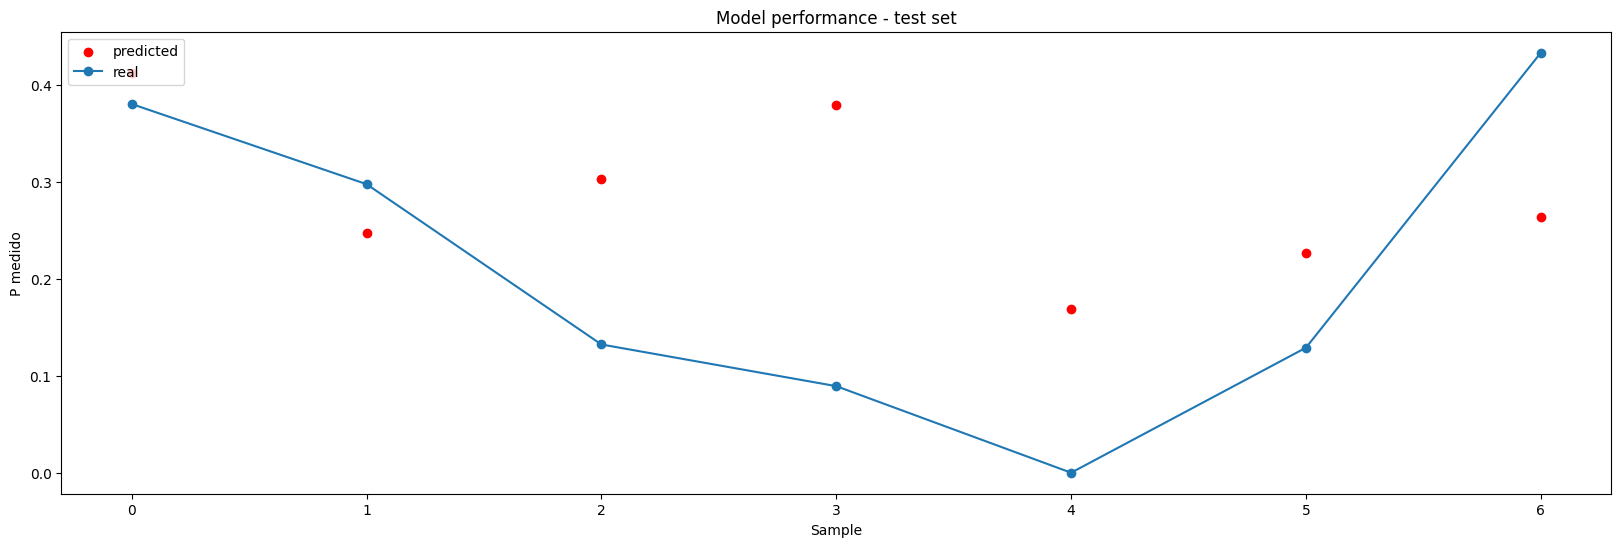

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

**Teste com 10-folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=10,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

Lambda:2.1021021021021022
Best MAE: 0.18534534323457236
Best MAPE: 51953039245883.195
R2: -2.8235114979324445


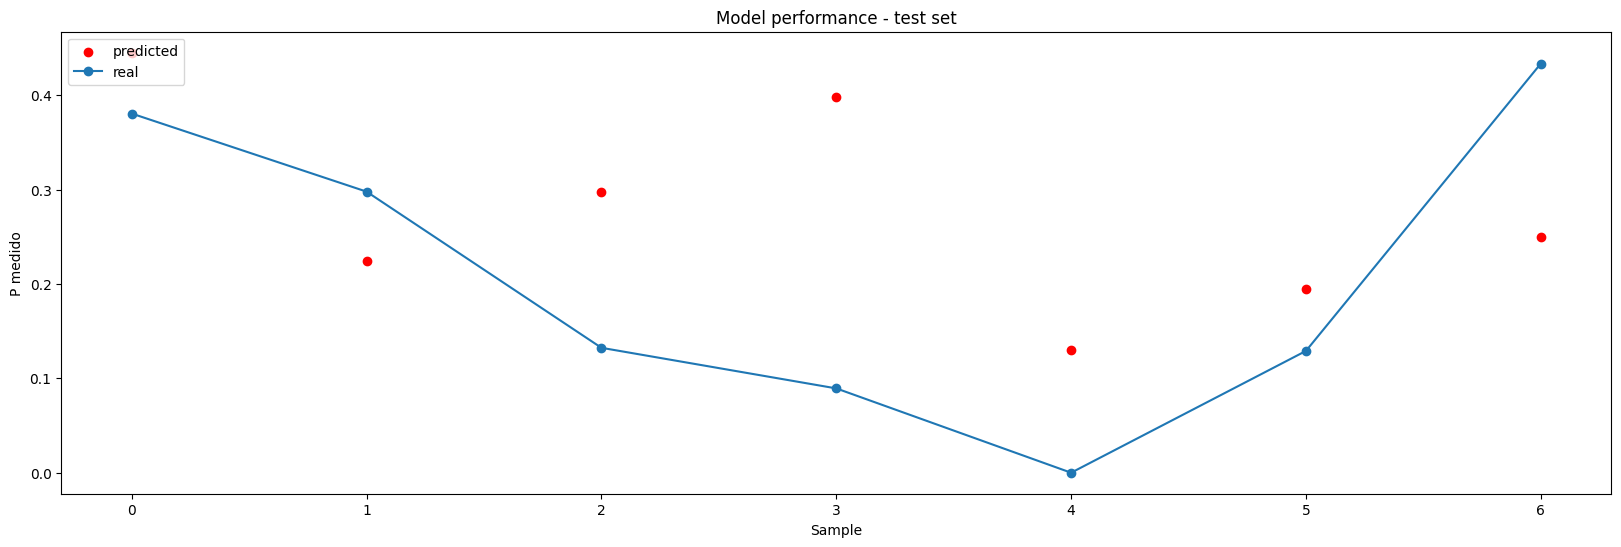

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

In [ ]:
y_pred = ridge.predict(x_te)
print('-----------Teste-------------')
print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

-----------Teste-------------
MAE: 0.14146677910003902
MAPE: 83466003032173.97
R2: -0.1821253736477364


##3.2 Métodos não lineares

###3.2.1. SVM

In [ ]:
from sklearn import svm

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.16673240320516364
Desvio padrão dos valore de MAE: 0.08305209199327351

Média dos valore de MAPE: 47225147570570.125
Desvio padrão dos valore de MAPE: 94450295141139.14

Média dos valore de R2: -0.012305640230307646
Desvio padrão dos valore de R2: 0.15800405884943816

--------------------Teste-----------------------
MAE: 0.09232540234952753
MAPE: 75953155873690.2
R2: 0.4508730508526476


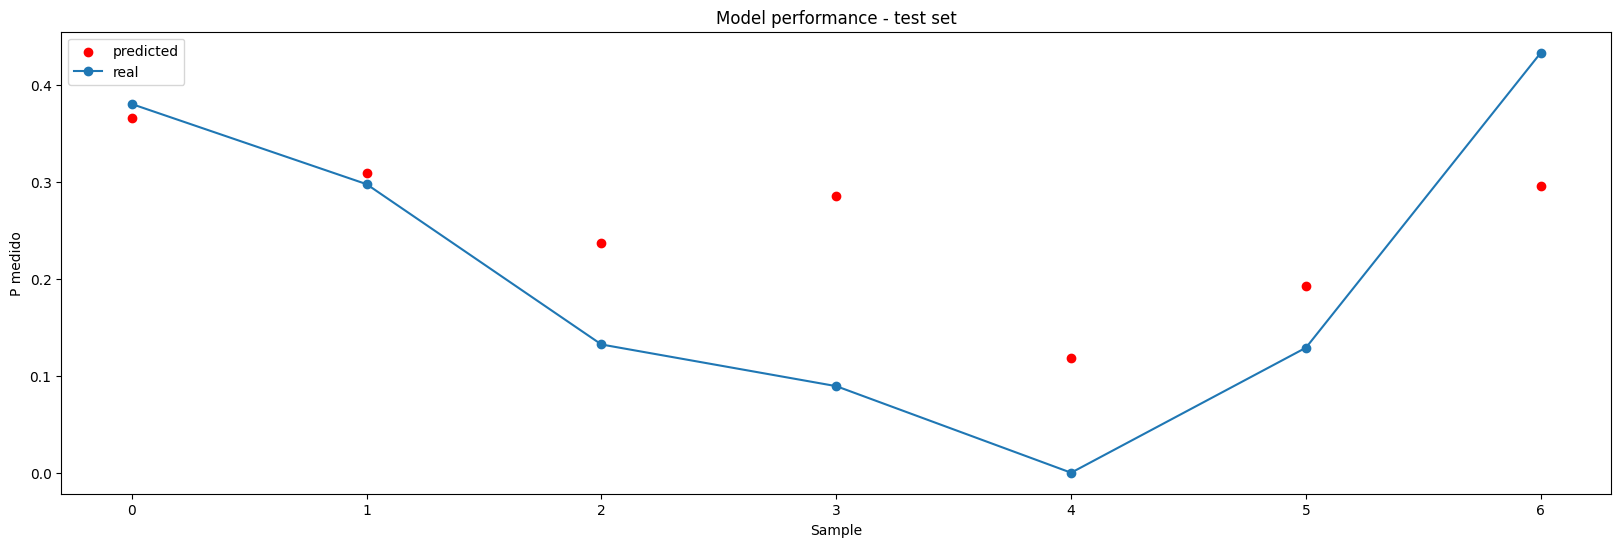

In [ ]:
svm_regressor = svm.SVR()
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.1568878376930546
Desvio padrão dos valore de MAE: 0.1110992520033438

Média dos valore de MAPE: 41286255009639.01
Desvio padrão dos valore de MAPE: 123858765028915.53

Média dos valore de R2: -3.574222035199747
Desvio padrão dos valore de R2: 10.942697313315243

--------------------Teste-----------------------
MAE: 0.09232540234952753
MAPE: 75953155873690.2
R2: 0.4508730508526476


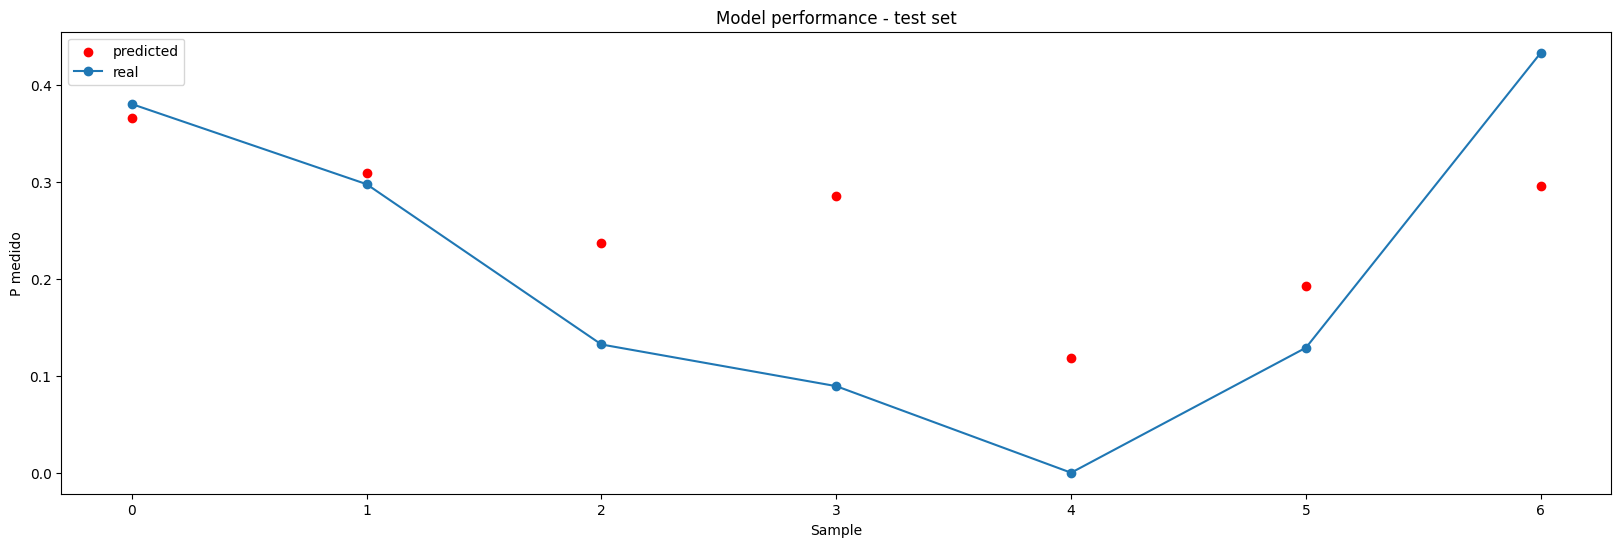

In [ ]:
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=10)

###3.2.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as rf

In [ ]:
rf_regressor = rf(n_estimators=1000, random_state=1)
rf_regressor.fit(x_tr, y_tr)

RandomForestRegressor(n_estimators=1000, random_state=1)

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.15798078126758958
Desvio padrão dos valore de MAE: 0.0575925364162479

Média dos valore de MAPE: 43919703843271.695
Desvio padrão dos valore de MAPE: 87839407686542.27

Média dos valore de R2: -0.5280406486177098
Desvio padrão dos valore de R2: 1.2180080705203893

--------------------Teste-----------------------
MAE: 0.22276402116402189
MAPE: 123617548434452.88
R2: -3.864979349428028


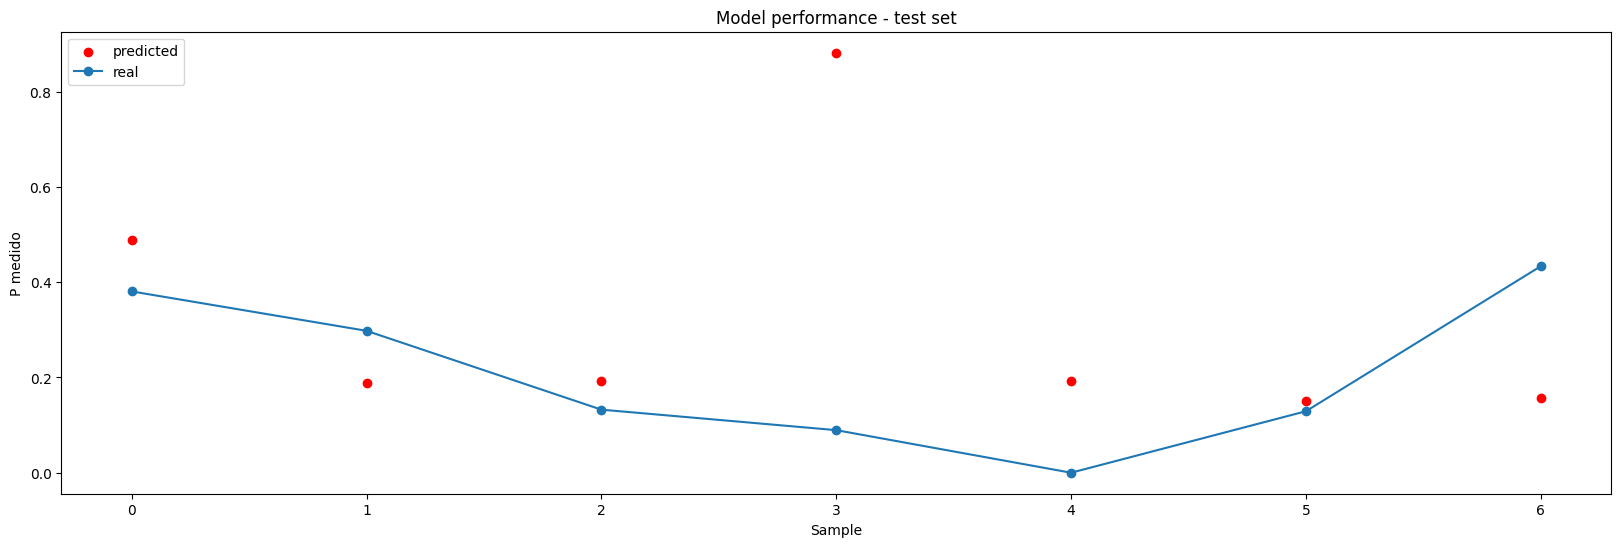

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.1552530522721301
Desvio padrão dos valore de MAE: 0.07798058177595073

Média dos valore de MAPE: 36852717972069.65
Desvio padrão dos valore de MAPE: 110558153916207.33

Média dos valore de R2: -2.0036693526437133
Desvio padrão dos valore de R2: 3.7561249677792685

--------------------Teste-----------------------
MAE: 0.22276402116402189
MAPE: 123617548434452.88
R2: -3.864979349428028


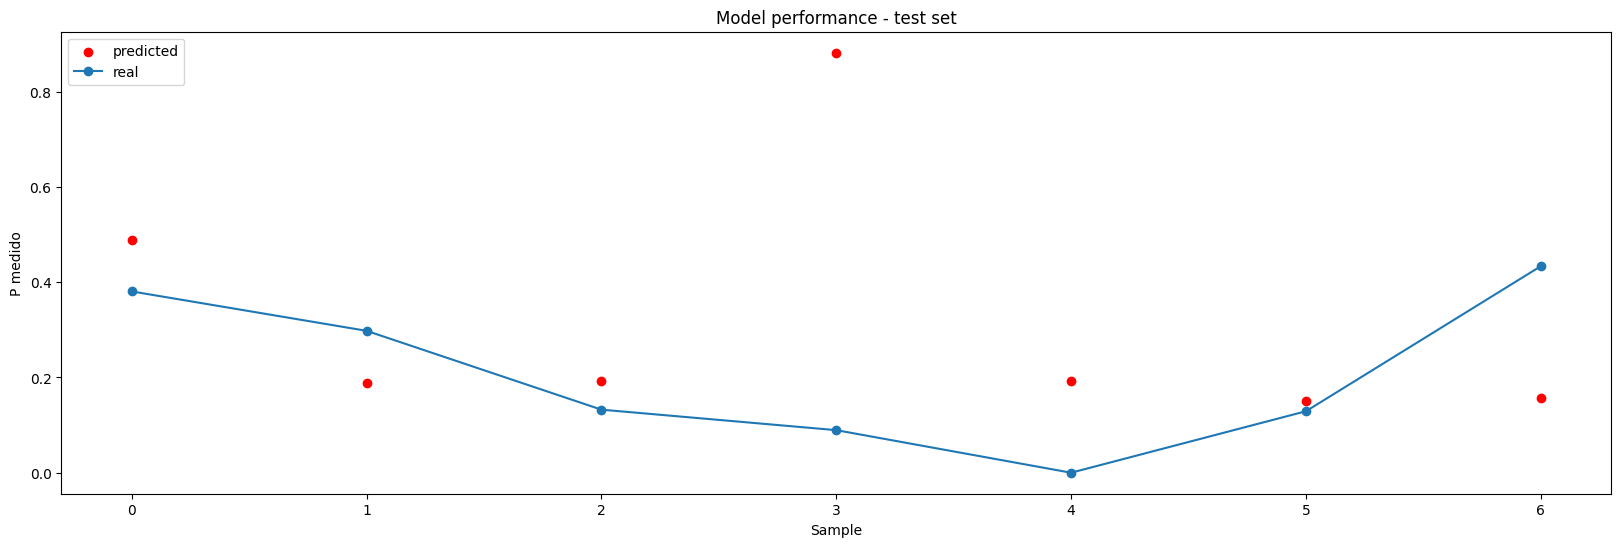

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=10)

###3.2.3 Gradient Boost

In [ ]:
%%capture
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [ ]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10, 20],
        'max_features': ['log2', 0.25, 'sqrt', 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(GradientBoostingRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

{'learning_rate': 0.3,
 'max_depth': 2,
 'max_features': 'log2',
 'min_samples_split': 5,
 'subsample': 0.5}

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.15352743310427822
Desvio padrão dos valore de MAE: 0.07468744076435974

Média dos valore de MAPE: 34562025565460.344
Desvio padrão dos valore de MAPE: 103686076696379.08

Média dos valore de R2: -1.3751816676482815
Desvio padrão dos valore de R2: 2.8711556353953545

--------------------Teste-----------------------
MAE: 0.27495910098892345
MAPE: 100413369779285.4
R2: -6.643992494826136


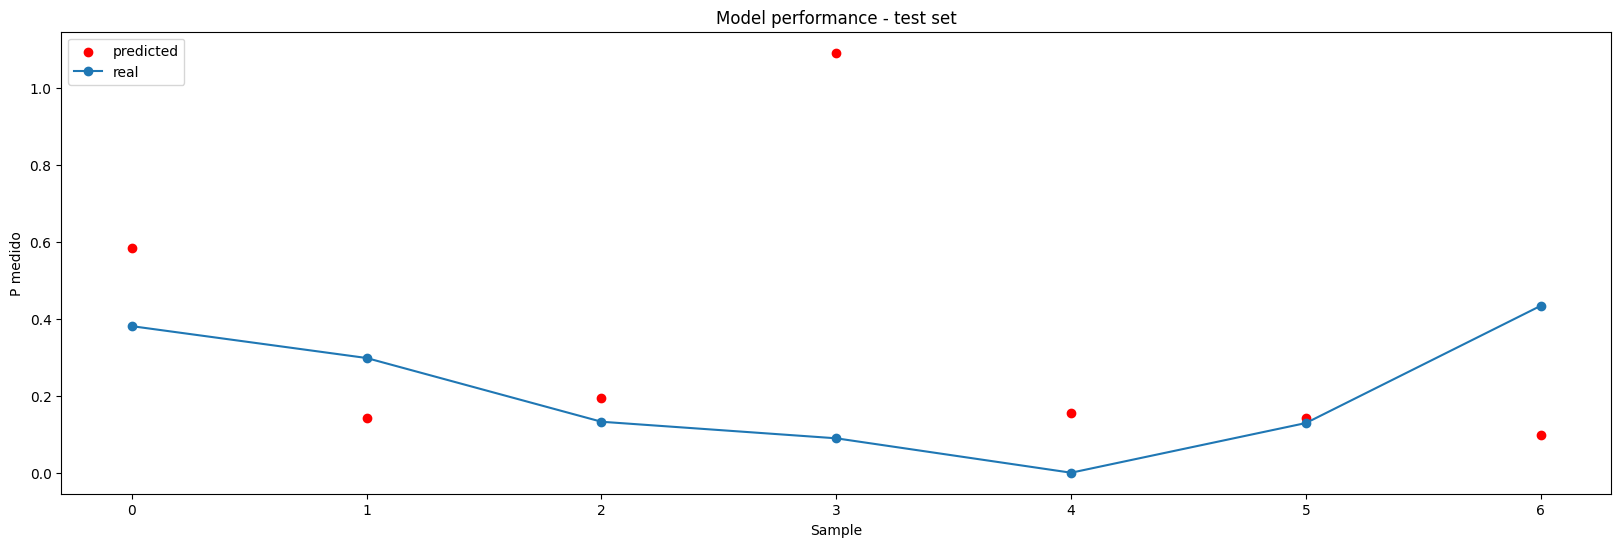

In [ ]:
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.3,max_depth=2,
 max_features='log2', min_samples_split=5, subsample=0.5
)


train_test_model(gb, x_tr, y_tr, x_te, y_te, folds=10)

### 3.2.4 CatBoost

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 6, 9],
        'leaf_estimation_iterations': [1, 10],
        'l2_leaf_reg': [1, 3, 6, 9]}

clf = GridSearchCV(CatBoostRegressor(iterations=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

0:	learn: 0.2342532	total: 707us	remaining: 141ms
1:	learn: 0.2248753	total: 1.84ms	remaining: 182ms
2:	learn: 0.2177172	total: 2.84ms	remaining: 186ms
3:	learn: 0.2095764	total: 3.86ms	remaining: 189ms
4:	learn: 0.2029215	total: 4.72ms	remaining: 184ms
5:	learn: 0.1960217	total: 5.56ms	remaining: 180ms
6:	learn: 0.1883948	total: 6.42ms	remaining: 177ms
7:	learn: 0.1830381	total: 7.23ms	remaining: 173ms
8:	learn: 0.1765320	total: 8.06ms	remaining: 171ms
9:	learn: 0.1696506	total: 8.93ms	remaining: 170ms
10:	learn: 0.1650904	total: 9.78ms	remaining: 168ms
11:	learn: 0.1589495	total: 11.7ms	remaining: 183ms
12:	learn: 0.1536245	total: 12.5ms	remaining: 179ms
13:	learn: 0.1491125	total: 13.2ms	remaining: 176ms
14:	learn: 0.1437838	total: 14ms	remaining: 173ms
15:	learn: 0.1404184	total: 14.7ms	remaining: 169ms
16:	learn: 0.1377021	total: 15.4ms	remaining: 166ms
17:	learn: 0.1338371	total: 16.1ms	remaining: 163ms
18:	learn: 0.1312216	total: 16.8ms	remaining: 160ms
19:	learn: 0.1266466	tota

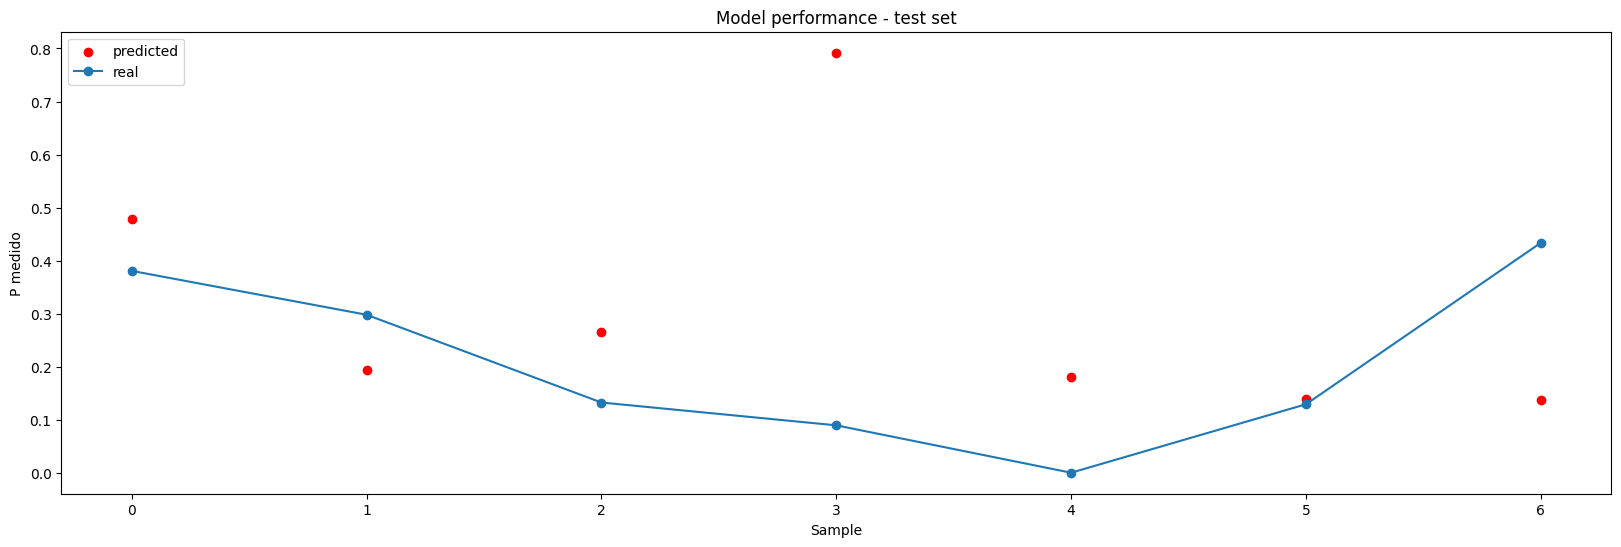

In [ ]:
ctb = CatBoostRegressor(n_estimators=200, l2_leaf_reg=9,
 leaf_estimation_iterations=10, learning_rate=0.05, max_depth=6
)


train_test_model(ctb, x_tr, y_tr, x_te, y_te, folds=10)

# 4. Testes com variáveis de entrada do SVM

Percebemos que a remoção das variáveis, por mais que elas pareçam redundantes, piora os resultados. Abaiixo testamos o conjunto de dados sem normalização. Perceba que o valor do $R^2$ apresenta uma piora significativa.

In [ ]:
dataset.columns

Index(['P', 'B2', 'B3', 'B3/B2', 'ln(B3)/ln(B2)', 'B3 ln(B2) / B2 ln(B3)'], dtype='object')

In [ ]:
data = dataset

In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(data[data.columns[1:]], data[data.columns[0]], test_size=0.15, random_state=3)

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.07120112558419513
Desvio padrão dos valore de MAE: 0.022918182779077815

Média dos valore de MAPE: 1.339667675778972
Desvio padrão dos valore de MAPE: 1.274415705598626

Média dos valore de R2: -20.02791872069764
Desvio padrão dos valore de R2: 54.782654801665885

--------------------Teste-----------------------
MAE: 0.06157419492840072
MAPE: 1.601057539825241
R2: -1.5847462475515592


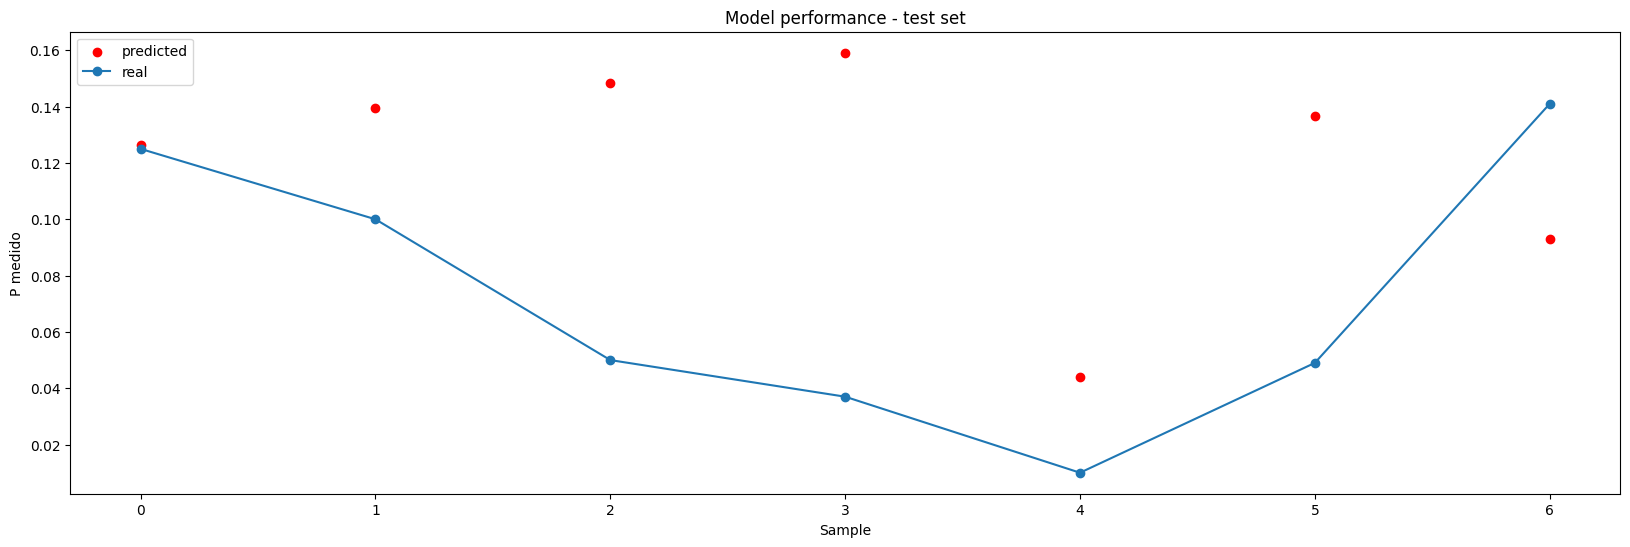

In [ ]:
svm_regressor = svm.SVR()
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=10)

#4. Resultados

O melhor resultado foi obtido pelo SVM, com um MAE de 0.0923 e $R^2$ de 0.45.

Revertendo a normalização

\begin{gather}
      y_{norm} = \frac{y - min}{max - min}\\
      y_{norm} \cdot (max-min) + min = y\\
      y = 0.0923 \cdot (0.312-0.01) + 0.01\\
      y = 0.0379 \text{ mg/L}
\end{gather}

Ou seja, o resultado acima indica que nosso modelo errou, em média, por aproximadamente 0.0379 mg/L da quantidade real de P medido do conjunto de teste.

In [ ]:
svm_regressor.fit(x_tr, y_tr)
y_pred = svm_regressor.predict(x_te)

In [ ]:
y_tes = y_te.tolist()
for i in range(len(y_pred)):
  y_pred[i] = y_pred[i]*(0.312 + 0.01) + 0.01
  y_tes[i] = y_tes[i]*(0.312 + 0.01) + 0.01

Transformamos os valores do conjunto de teste e os valores preditos pelo modelo de regressão para a unidade original (mg/L)

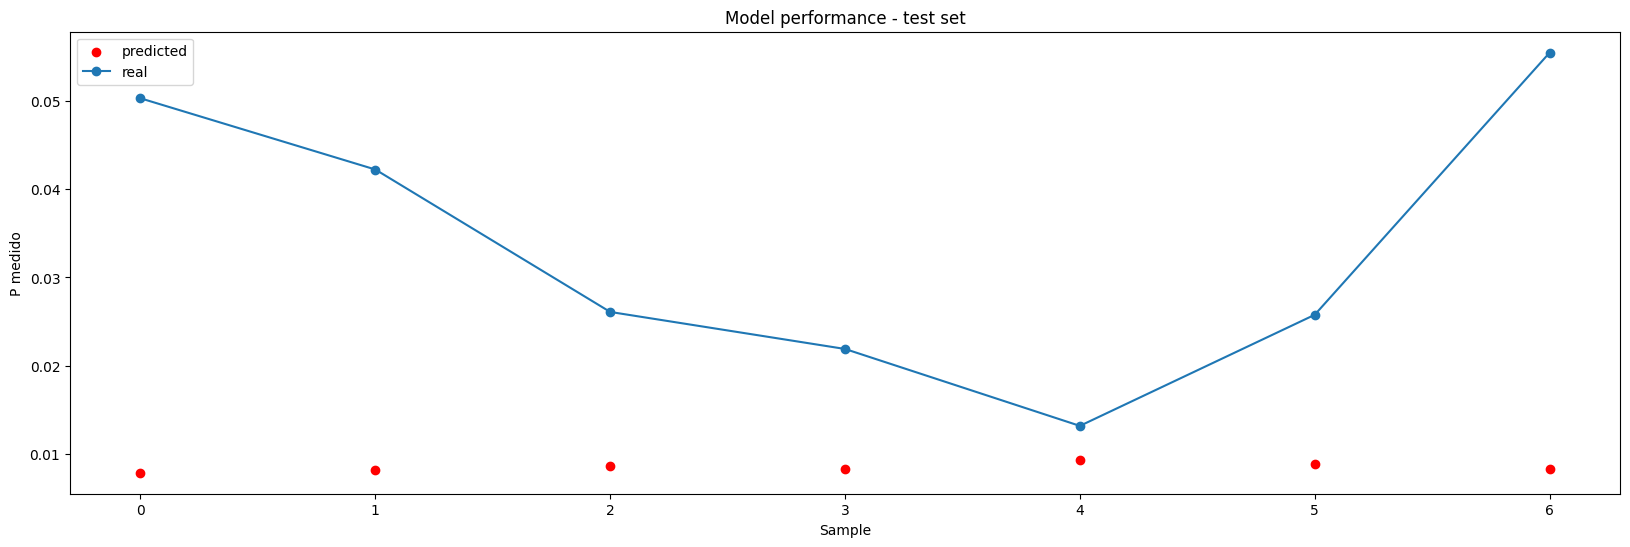

In [ ]:
plot_results(y_pred, y_tes)

#5. Conclusões



*   Como não conheço as características do problema, não sei se os valores para os erros médios obtidos são aceitáveis;

*   Mesmo não conhecendo a natureza do problema, recomendo fortemente a busca por novas variáveis. Como vimos, a informação das variáveis B2 e B3 é redundante. Além disso, essas variáveis parecem fornecer pouca informação sobre a variável P;

*   Para termos mais confiança nos resultados, seriam necessários mais dados, pois, quanto menos dados de teste, menor nossa certeza na capacidade de generalização do modelo;

*   Por fim, a adição das novas relações entre B2 e B3 melhoraram os resultados






In [ ]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%writefile no_code.tpl
{% extends 'article.tplx' %}

{% block input_group %}
{% endblock input_group %}

Writing no_code.tpl


In [ ]:
!cp /content/drive/MyDrive/CNN_Chagas/fosforo/Cópia_de_Analise_fosforo.ipynb ./

In [ ]:
!jupyter nbconvert --to pdf --template no_code.tpl  "Cópia_de_Analise_fosforo.ipynb"